<a href="https://colab.research.google.com/github/gabrielpetersson/simple-variational-auto-encoder/blob/master/variational_auto_encoder_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


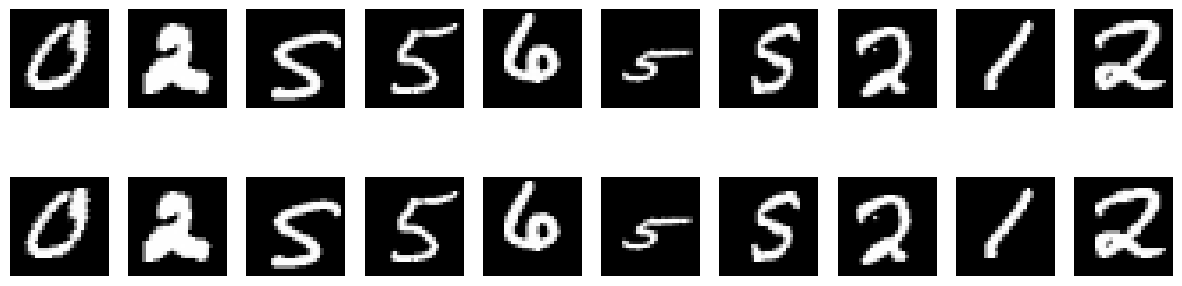

torch.Size([1, 28, 28])


In [18]:
def show_images(images, outputs, n=10):
    images = images[:n]
    outputs = outputs[:n]
    images = images.cpu().numpy()
    outputs = outputs.cpu().detach().numpy()

    # Denormalize images
    images = images * 0.5 + 0.5
    outputs = outputs * 0.5 + 0.5

    fig, axes = plt.subplots(nrows=2, ncols=n, sharex=True, sharey=True, figsize=(15,4))

    for images_row, row in zip([images, outputs], axes):
        for img, ax in zip(images_row, row):
            img = np.squeeze(img)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    plt.show()


transform = transforms.Compose([
    transforms.RandomCrop(28, padding=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

for images, labels in train_loader:
  show_images(images, images)
  print(images[0].shape)
  break

In [3]:
import torch
import torch.nn as nn

bottleneck = 8  # dimensionality of the latent space
first = 64
second = 128
third = 256

#first = 64 * 3
#second = 128 * 3
#third = 256 * 3

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, first, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(first),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.2),

            nn.Conv2d(first, second, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(second),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.2),

            nn.Conv2d(second, third, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(third),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.2),

            nn.Flatten()
        )

        # Separate layers for mean and log-variance
        self.fc_mu = nn.Linear(third * 4 * 4, bottleneck)
        self.fc_logvar = nn.Linear(third * 4 * 4, bottleneck)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, third * 4 * 4),
            nn.BatchNorm1d(third * 4 * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.2),

            nn.Unflatten(1, (third, 4, 4)),
            nn.ConvTranspose2d(third, second, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(second),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.2),

            nn.ConvTranspose2d(second, first, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(first),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.2),

            nn.ConvTranspose2d(first, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Calculate the standard deviation
        eps = torch.randn_like(std)    # Sample epsilon from a standard normal distribution
        return mu + eps * std          # Reparameterization trick

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)       # Mean of the latent space
        logvar = self.fc_logvar(encoded)  # Log-variance of the latent space
        z = self.reparameterize(mu, logvar)  # Sample from the latent space
        decoded = self.decoder(z)      # Decode the sampled latent vector
        return decoded, z, mu, logvar # also return z so we can play with it

def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


Initial validation loss: 591.4722138671875


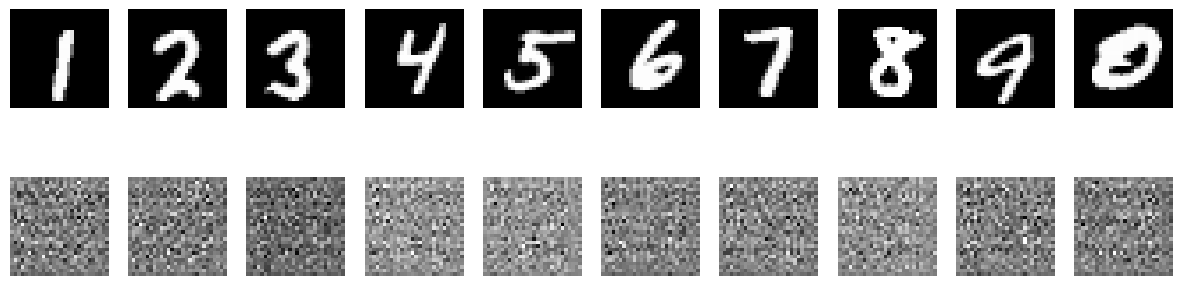

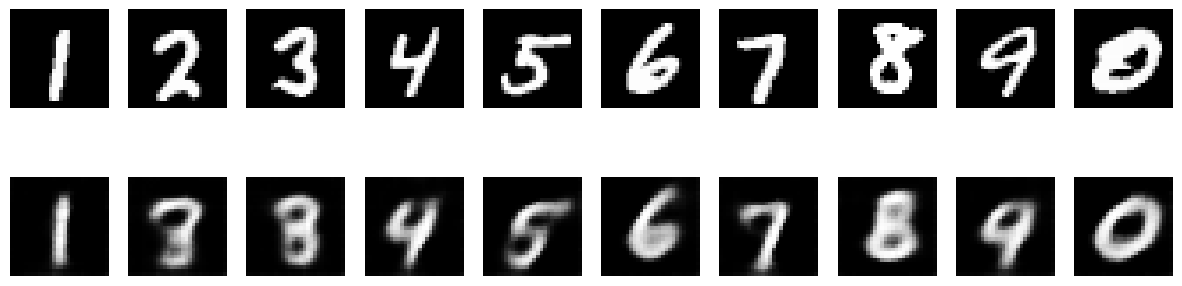

Epoch [1/10], Training Loss: 188.0913, Validation Loss: 122.0940, Learning rate: 0.005


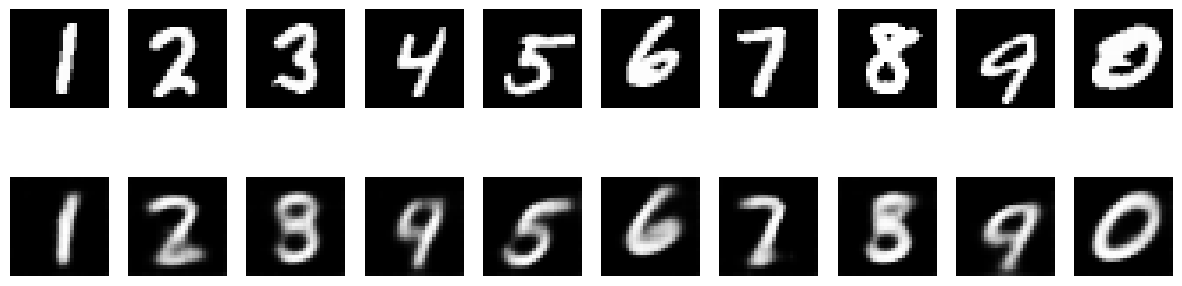

Epoch [2/10], Training Loss: 124.9520, Validation Loss: 111.6982, Learning rate: 0.005


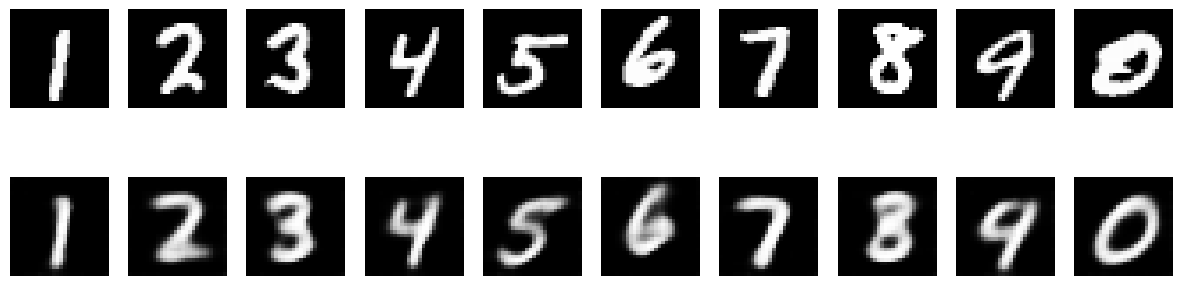

Epoch [3/10], Training Loss: 116.4517, Validation Loss: 105.6592, Learning rate: 0.005


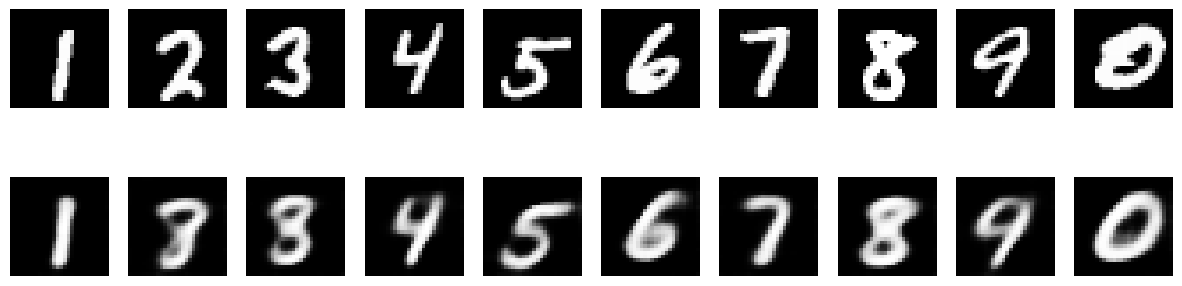

Epoch [4/10], Training Loss: 111.0283, Validation Loss: 99.0717, Learning rate: 0.005


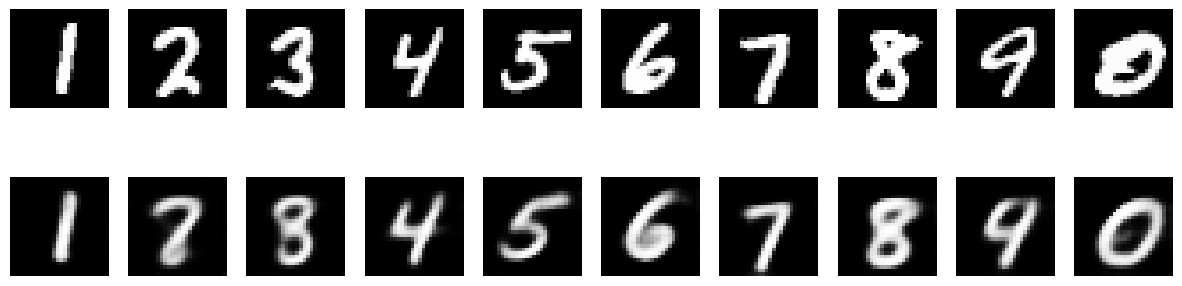

Epoch [5/10], Training Loss: 107.1626, Validation Loss: 94.9587, Learning rate: 0.005


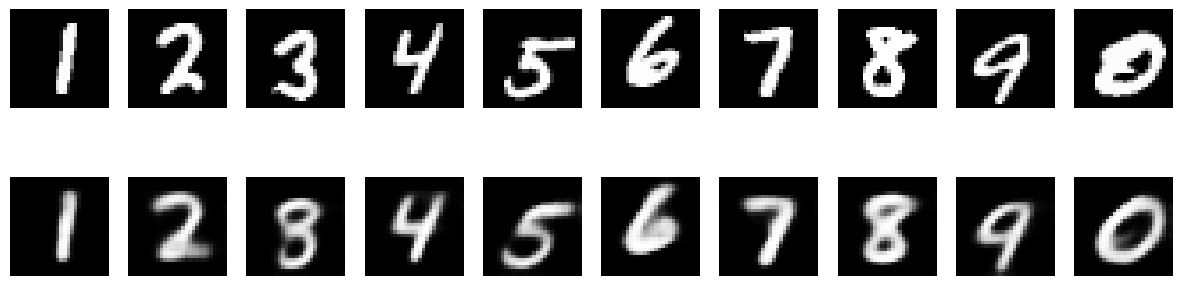

Epoch [6/10], Training Loss: 105.0459, Validation Loss: 91.9659, Learning rate: 0.005


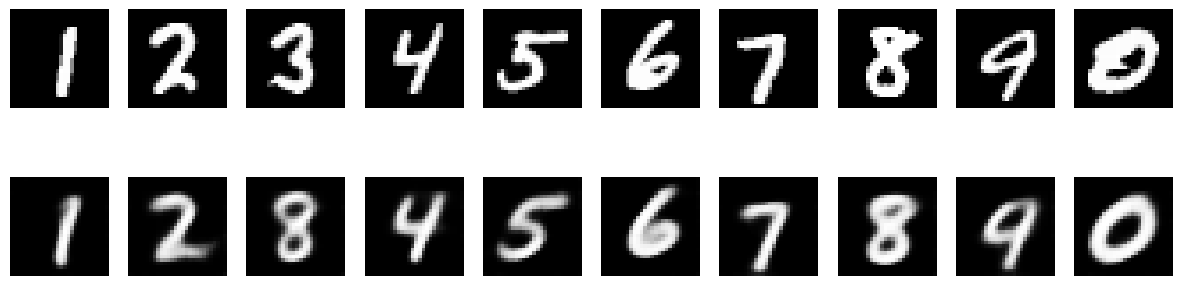

Epoch [7/10], Training Loss: 103.3257, Validation Loss: 90.9661, Learning rate: 0.005


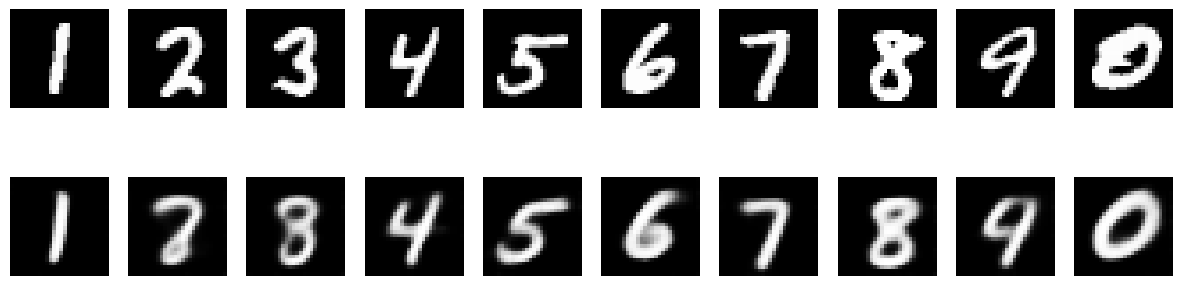

Epoch [8/10], Training Loss: 102.1321, Validation Loss: 89.0058, Learning rate: 0.005


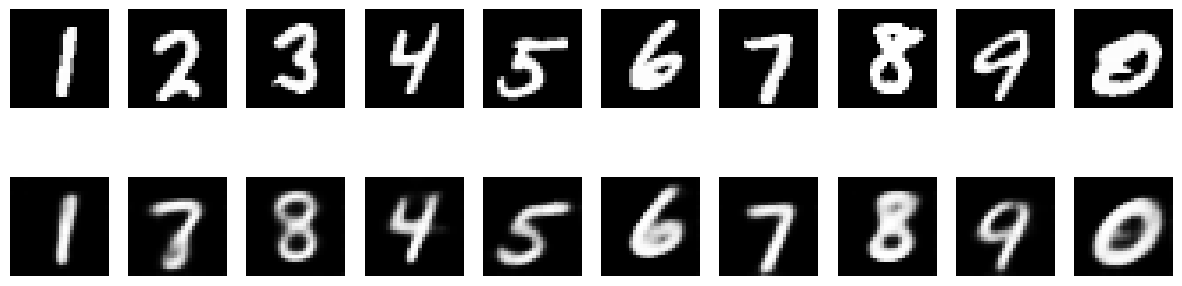

Epoch [9/10], Training Loss: 101.1131, Validation Loss: 89.0147, Learning rate: 0.005


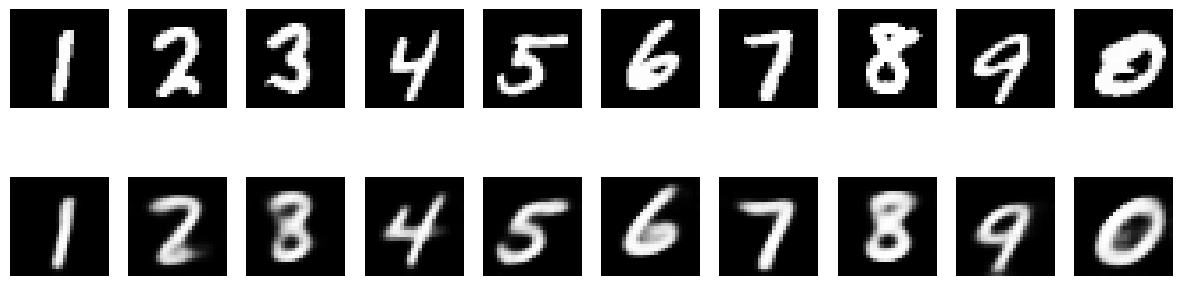

Epoch [10/10], Training Loss: 100.3901, Validation Loss: 87.4339, Learning rate: 0.005


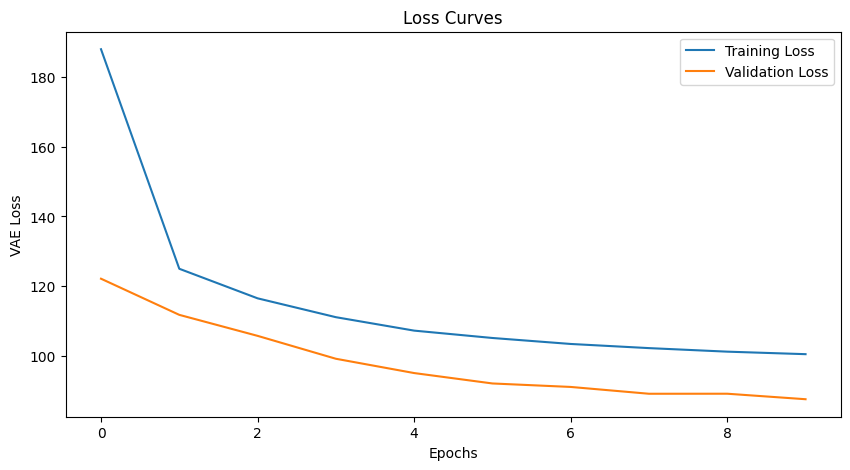

Model checkpoint saved at epoch 10


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
torch.autograd.set_detect_anomaly(True)
num_epochs = 10
learning_rate = 5e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VariationalAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, patience=1, factor=0.5, min_lr=1e-5)

train_losses = []
val_losses = []

model.eval()
val_loss = 0
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs, _, mu, logvar = model(images)
        loss = vae_loss_function(outputs, images, mu, logvar)
        val_loss += loss.item()
    val_loss /= len(test_loader.dataset)
    print("Initial validation loss:", val_loss)
    show_images(images, outputs)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)

        outputs, _, mu, logvar = model(images)
        loss = vae_loss_function(outputs, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs, _, mu, logvar = model(images)
            loss = vae_loss_function(outputs, images, mu, logvar)
            val_loss += loss.item()

        val_loss /= len(test_loader.dataset)
        val_losses.append(val_loss)

        show_images(images[:10], outputs[:10])

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning rate: {optimizer.param_groups[0]["lr"]}')
    scheduler.step(val_loss)

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('VAE Loss')
plt.legend()
plt.show()

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, '/content/drive/MyDrive/model_checkpoints/vae_checkpoint.pth')

print(f'Model checkpoint saved at epoch {epoch+1}')



In [4]:
import pandas as pd
zs = []

model = VariationalAutoencoder().to("cuda")
checkpoint = torch.load('/content/drive/MyDrive/model_checkpoints/vae_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

for i in range(10):
  model.eval()
  with torch.no_grad():
      images, _ = next(iter(test_loader))
      image = images[0].to("cuda").view(1,1,28,28)
      decoded, encoded, _, _ = model(image)
      #show_images(image[:1], decoded)
      zs.append([round(x, 5) for x in encoded.tolist()[0]])

original_df = pd.DataFrame(zs)
df = original_df.copy()
original_df

# the digit 7 has very similar activations on col index 9 12 14, exploring what happens if we tweak those

<ipython-input-4-a20a5d1b44a8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/model_checkpoints/vae_checkpoint.pth')


,0,1,2,3,4,5,6,7
0,2.33088,0.02542,1.39963,-0.21601,-0.55482,0.07396,0.51339,-0.98551
1,2.09652,0.69379,0.02643,-1.18168,0.30723,-0.82050,1.03312,-0.45112
2,2.26873,0.48196,0.65656,-0.84207,-0.34153,-0.65667,0.87249,-0.99982
3,2.28575,0.90515,0.33007,-1.04324,-0.54175,-0.71376,0.44433,-1.07009
4,2.06676,0.48396,0.13494,-1.21092,0.28178,-0.97326,0.89973,-0.63784
5,2.09448,0.65000,0.15246,-1.19841,0.39485,-0.74789,0.83911,-0.48945
6,2.47783,0.32471,0.86013,-0.66282,-0.16394,-0.38630,0.93591,-0.91671
7,2.29490,0.55178,-0.12111,-1.28678,0.17679,-0.79956,0.88829,-0.63241
8,2.39371,0.29501,0.47128,-1.01185,0.25157,-0.29930,1.25563,-0.76399
9,2.24133,0.47649,0.64308,-0.88602,0.18940,-0.09896,1.42458,-0.42495


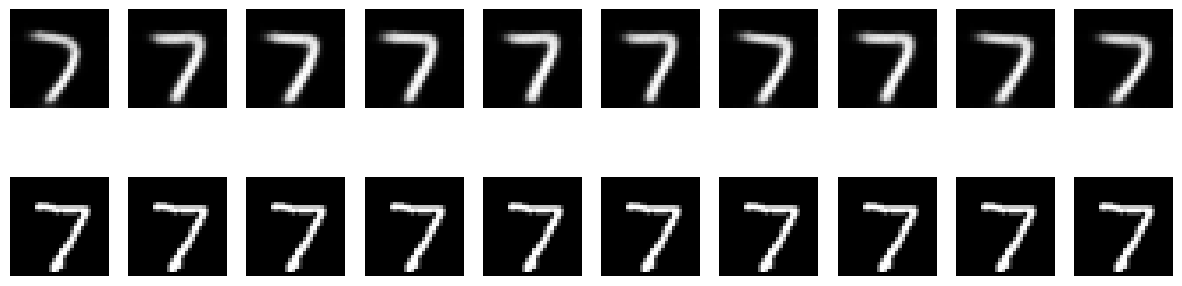

,0,1,2,3,4,5,6,7
0,2.33088,0.0,0.0,-0.21601,-0.55482,0.07396,0.51339,-0.98551
1,2.09652,0.0,0.0,-1.18168,0.30723,-0.82050,1.03312,-0.45112
2,2.26873,0.0,0.0,-0.84207,-0.34153,-0.65667,0.87249,-0.99982
3,2.28575,0.0,0.0,-1.04324,-0.54175,-0.71376,0.44433,-1.07009
4,2.06676,0.0,0.0,-1.21092,0.28178,-0.97326,0.89973,-0.63784
5,2.09448,0.0,0.0,-1.19841,0.39485,-0.74789,0.83911,-0.48945
6,2.47783,0.0,0.0,-0.66282,-0.16394,-0.38630,0.93591,-0.91671
7,2.29490,0.0,0.0,-1.28678,0.17679,-0.79956,0.88829,-0.63241
8,2.39371,0.0,0.0,-1.01185,0.25157,-0.29930,1.25563,-0.76399
9,2.24133,0.0,0.0,-0.88602,0.18940,-0.09896,1.42458,-0.42495


In [5]:

model.eval()

df = original_df.copy()

zero = [x for x in range(df.shape[1]) if x in [1, 2]]
df.iloc[:, zero] = 0

output = model.decoder(torch.tensor(df.to_numpy(), dtype=torch.float32).to("cuda"))
show_images(output.detach(), image.repeat(10, 1, 1, 1))
df

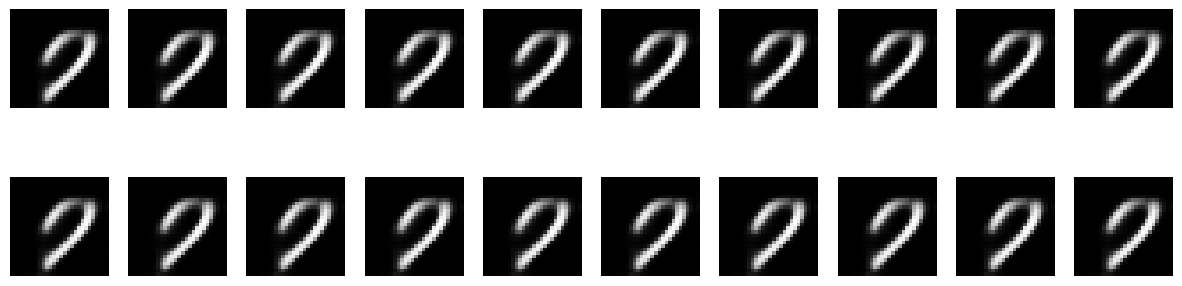

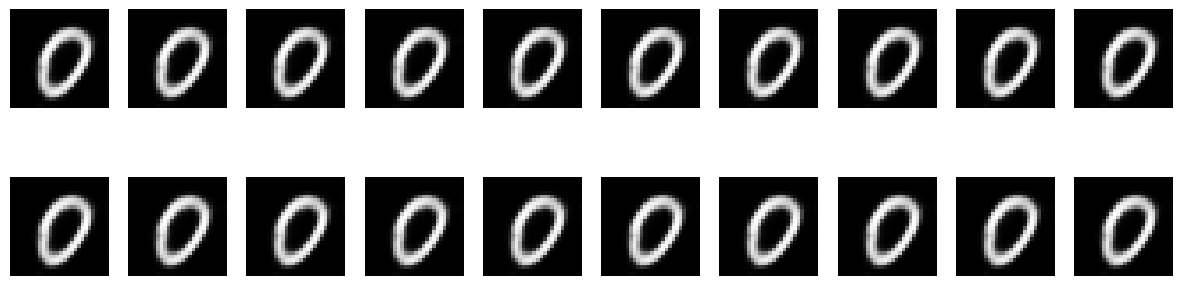

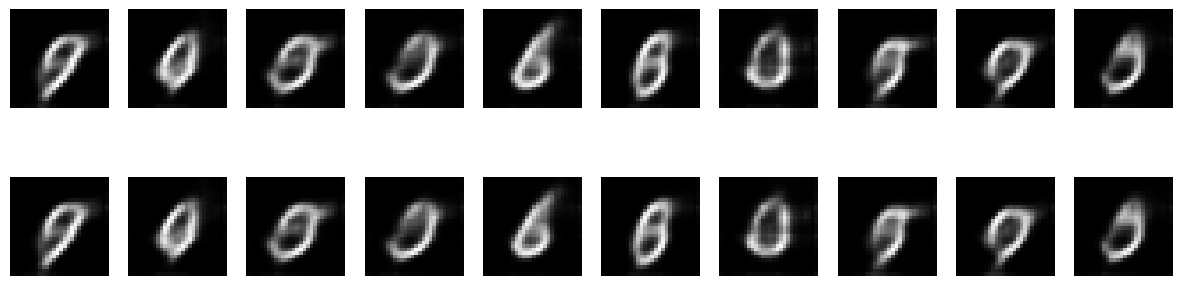

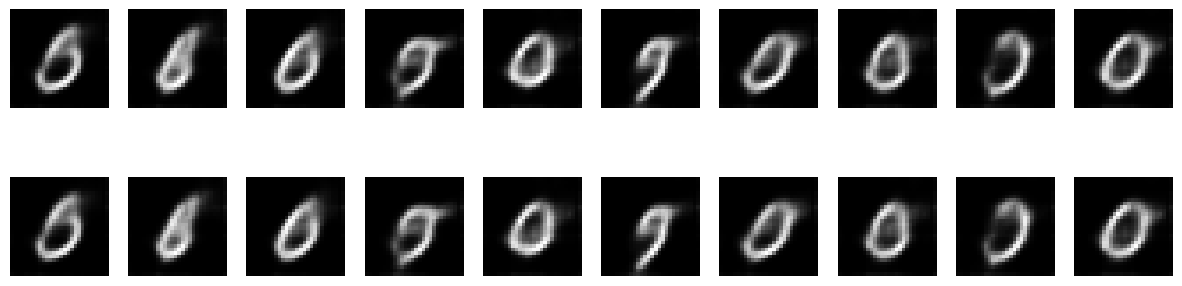

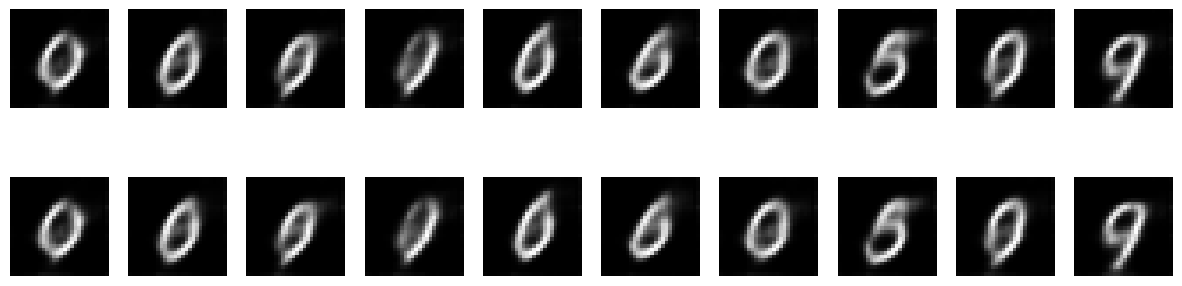

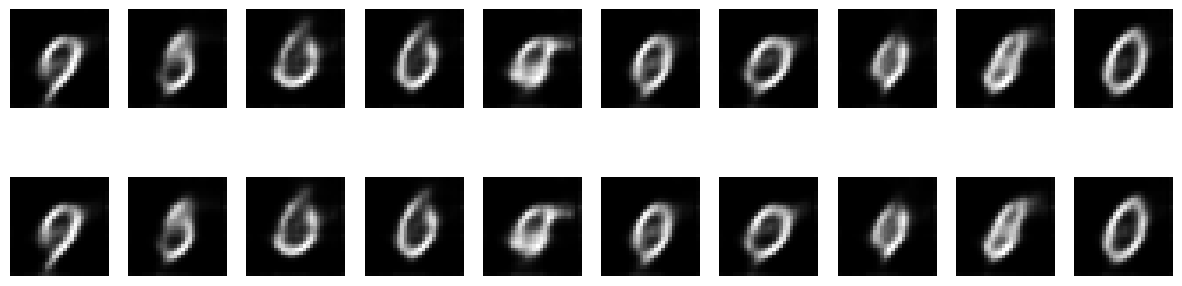

In [6]:
# take an encoding/bottleneck from above and modify it slightly to see what happens

embed = torch.tensor([1.12115,	1.19094,	0.48662,	-0.96903,	0.50208,	-0.45426,	2.01690,	1.48092]).unsqueeze(0).repeat(10, 1).to("cuda")
random_inputs = torch.rand(10, bottleneck).to("cuda")
outputs = model.decoder(embed)
show_images(outputs.detach()[:10], outputs[:10])

embed = torch.tensor([0,	0,	0,	-0.96903,	0.50208,	-0.45426,	2.01690,	1.48092]).unsqueeze(0).repeat(10, 1).to("cuda")
random_inputs = torch.rand(10, bottleneck).to("cuda")
outputs = model.decoder(embed)
show_images(outputs.detach()[:10], outputs[:10])

# sample randomly from our gaussian
random_inputs = torch.rand(10, bottleneck).to("cuda")
outputs = model.decoder(random_inputs)
show_images(outputs.detach()[:10], outputs[:10])
random_inputs = torch.rand(10, bottleneck).to("cuda")
outputs = model.decoder(random_inputs)
show_images(outputs.detach()[:10], outputs[:10])
random_inputs = torch.rand(10, bottleneck).to("cuda")
outputs = model.decoder(random_inputs)
show_images(outputs.detach()[:10], outputs[:10])
random_inputs = torch.rand(10, bottleneck).to("cuda")
outputs = model.decoder(random_inputs)
show_images(outputs.detach()[:10], outputs[:10])



In [21]:
import pandas as pd


#model = VariationalAutoencoder().to("cuda")
#checkpoint = torch.load('/content/drive/MyDrive/model_checkpoints/vae_checkpoint.pth')
#model.load_state_dict(checkpoint['model_state_dict'])


with torch.no_grad():
    images, _ = next(iter(train_loader))
    images = images.to("cuda")
    _, encoded, _, _ = model(images)
    print(encoded.shape)




torch.Size([2048, 8])


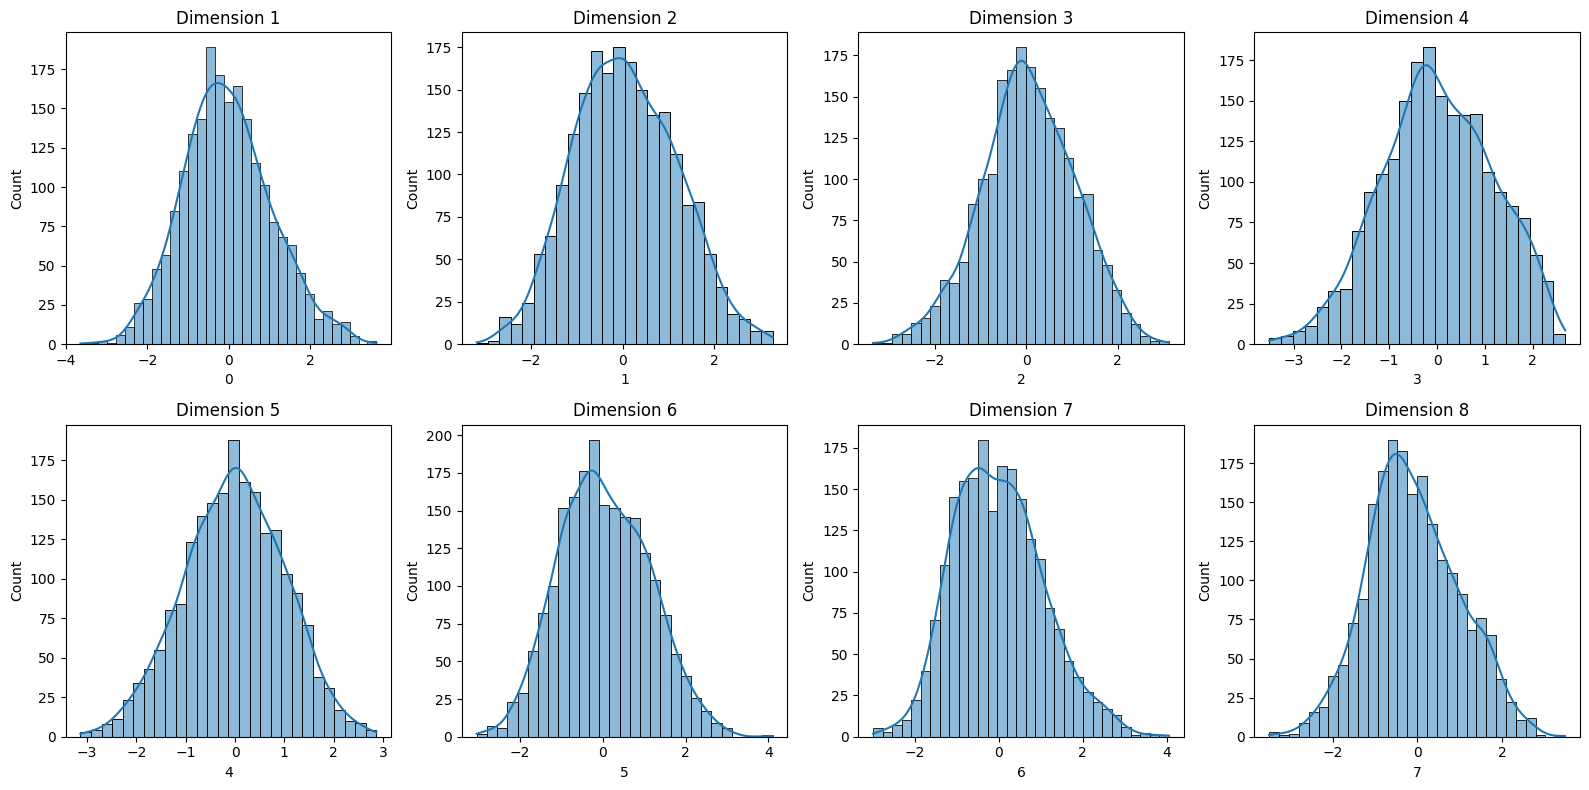

In [32]:
# guassian distribution of our dimensions

import seaborn as sns

encoded_df = pd.DataFrame(encoded.cpu().numpy())


fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.histplot(encoded_df.iloc[:, i], ax=ax, kde=True)
    ax.set_title(f"Dimension {i + 1}")

plt.tight_layout()
plt.show()